In [1]:
import os
import re
import time
import copy

from pathlib import Path
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import seaborn as sns
import torchvision
from torchvision import models, datasets, transforms

# import online augmentation libraries
from augmentation_libraries.online_augmentation import augment_image_without_seed

print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)
print(torch.cuda.is_available())

PyTorch Version:  2.1.0+cu118
Torchvision Version:  0.16.0+cu118
True


input dir

In [ ]:
CURRENT_DIR = os.getcwd()
MAIN_FOLDER = Path(CURRENT_DIR).parent
OUTPUT_FOLDER = os.path.join(MAIN_FOLDER, 'aligned')  
FOLD_DATA = os.path.join(MAIN_FOLDER, 'fold_data') 

BATCH_SIZE = 64

cuda_avail = torch.cuda.is_available()
DEVICE = torch.device("cuda:1" if cuda_avail else "cpu")

print(
    f"Current Directory: {CURRENT_DIR}\n",
    f"Main Folder: {MAIN_FOLDER}\n",
    f"Output Folder: {OUTPUT_FOLDER}\n",
    f"Fold Data Folder: {FOLD_DATA}\n",
)

Current Directory: /home/user/CZ4042-SC4001-NND/architecture
 Main Folder: /home/user/CZ4042-SC4001-NND
 Output Folder: /home/user/CZ4042-SC4001-NND/aligned
 Fold Data Folder: /home/user/CZ4042-SC4001-NND/fold_data



Data processing

In [3]:
# Data Transforms
def get_data_transforms():
    normalize = [0.5, 0.5, 0.5], [0.5, 0.5, 0.5]
    common_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(*normalize)
    ])
    return {
        'train': common_transform,
        'val': common_transform,
        'test': common_transform
    }

data_transforms = get_data_transforms()

In [4]:
class BasicImageDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None, augment=False, num_augmentations=2):
        """
        Args:
            image_paths (list): List of image file paths.
            labels (list): List of corresponding labels.
            transform (callable, optional): Transformations to apply to the images.
            augment (bool): Whether to apply online augmentation.
            num_augmentations (int): Number of augmented versions to create per image.
        """
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
        self.augment = augment
        self.num_augmentations = num_augmentations
        
    def __len__(self):
        # Return the actual number of samples after augmentation
        if self.augment:
            return len(self.image_paths) * (self.num_augmentations)
        return len(self.image_paths)
        
    def get_original_len(self):
        """Return the number of original images (without augmentation)"""
        return len(self.image_paths)
        
    def __getitem__(self, idx):
        # Calculate which original image to use
        if self.augment:
            original_idx = idx // self.num_augmentations
        else:
            original_idx = idx
            
        image = Image.open(self.image_paths[original_idx]).convert('RGB')
        label = torch.tensor(self.labels[original_idx], dtype=torch.long)

        if self.augment:
            # When augmenting, first apply augmentation (which already returns a tensor)
            augmented_tensor = augment_image_without_seed(image, final_resolution=(224, 224))
            
            # Skip ToTensor and only apply normalization if needed
            if self.transform:
                # Extract the normalization from transform and apply it directly
                for t in self.transform.transforms:
                    if isinstance(t, transforms.Normalize):
                        augmented_tensor = t(augmented_tensor)
                        
            return augmented_tensor, label

        # For non-augmented images, apply the full transform
        if self.transform:
            image = self.transform(image)
        else:
            image = transforms.ToTensor()(image)

        return image, label

In [5]:
def load_folds_dataset(image_root, fold_dir, fold_files):
    image_paths = []
    labels = []

    for fold_file in fold_files:
        print(f"Reading fold file: {fold_file}")
        with open(os.path.join(fold_dir, fold_file), 'r') as f:
            next(f)  
            for line in f:
                parts = line.strip().split('\t')
                if len(parts) < 5:
                    continue
                user_id = parts[0]
                original_img_name = parts[1]
                gender = parts[4].lower()

                if gender not in ["m", "f"]:
                    continue
                label = 0 if gender == "m" else 1

                user_folder = os.path.join(image_root, user_id)
                if not os.path.isdir(user_folder):
                    continue

                for file in os.listdir(user_folder):
                    if original_img_name in file:
                        full_path = os.path.join(user_folder, file)
                        if os.path.isfile(full_path):
                            image_paths.append(full_path)
                            labels.append(label)
                        break

    return image_paths, labels


In [6]:
def get_dataloaders(batch_size, train_folds, val_fold):
    train_image_paths, train_labels = load_folds_dataset(OUTPUT_FOLDER, FOLD_DATA, train_folds)
    val_image_paths, val_labels = load_folds_dataset(OUTPUT_FOLDER, FOLD_DATA, [val_fold])

    train_dataset = BasicImageDataset(train_image_paths, train_labels, transform=data_transforms['train'], augment=True)
    val_dataset = BasicImageDataset(val_image_paths, val_labels, transform=data_transforms['val'], augment=False)

    print(f"Train size: {len(train_dataset)} (from {train_dataset.get_original_len()} original images)")
    print(f"Val size: {len(val_dataset)}")

    if train_dataset.get_original_len() == 0 or len(val_dataset) == 0:
        return None

    num_workers = 16 if cuda_avail else 0
    pin_memory = True if cuda_avail else False
    # Create DataLoader for training and validation datasets
    # Use num_workers and pin_memory only if CUDA is available
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=pin_memory)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=pin_memory)

    return {'train': train_loader, 'val': val_loader}

model

In [ ]:
class ResNetGender(nn.Module):
    def __init__(self, layers=18, pretrained=True, drop_rate=0.3):
        super(ResNetGender, self).__init__()

        if layers == 18:
            base_model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT if pretrained else None)
            block_expansion = 1
        elif layers == 34:
            base_model = models.resnet34(weights=models.ResNet34_Weights.DEFAULT if pretrained else None)
            block_expansion = 1
        elif layers == 50:
            base_model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT if pretrained else None)
            block_expansion = 4
        else:
            raise ValueError("Only ResNet18, 34, 50 are supported")

        self.backbone = base_model  # Store base for unfreezing access
        self.features = nn.Sequential(
            base_model.conv1,
            base_model.bn1,
            base_model.relu,
            base_model.maxpool,
            base_model.layer1,
            base_model.layer2,
            base_model.layer3,
            base_model.layer4,
        )

        self.avgpool = base_model.avgpool  # AdaptiveAvgPool2d((1, 1))

        in_features = 512 * block_expansion
        if layers == 50:
            hidden1, hidden2 = 512, 256
        else:
            hidden1, hidden2 = 256, 128

        self.fc = nn.Sequential(
            nn.Linear(in_features, hidden1),
            nn.BatchNorm1d(hidden1),
            nn.ReLU(),
            nn.Dropout(drop_rate),
            nn.Linear(hidden1, hidden2),
            nn.BatchNorm1d(hidden2),
            nn.ReLU(),
            nn.Dropout(drop_rate),
            nn.Linear(hidden2, 2)  # For CrossEntropyLoss
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x


In [ ]:
def freeze_all_layers(model):
    for param in model.backbone.parameters():
        param.requires_grad = False

def unfreeze_layers(model, stage):
    """
    Gradually unfreezes layers in ResNet backbone.
    stage: 0 = all frozen, 1 = layer4, 2 = layer3+4, ..., 4 = all
    """
    assert 0 <= stage <= 4, "Stage must be 0–4"
    layer_names = ['layer4', 'layer3', 'layer2', 'layer1']
    layers_to_unfreeze = layer_names[:stage][::-1]  # Start from layer4 and go backward

    for name, module in model.backbone.named_children():
        if name in layers_to_unfreeze:
            for param in module.parameters():
                param.requires_grad = True
        elif name.startswith('layer'):
            for param in module.parameters():
                param.requires_grad = False  # re-freeze others if needed


In [8]:
class LabelSmoothingCrossEntropy(nn.Module):
    def __init__(self, eps=0.1, reduction='mean'):
        super(LabelSmoothingCrossEntropy, self).__init__()
        self.eps = eps
        self.reduction = reduction

    def forward(self, output, target):
        c = output.size()[-1]
        log_preds = F.log_softmax(output, dim=-1)
        if self.reduction=='sum':
            loss = -log_preds.sum()
        else:
            loss = -log_preds.sum(dim=-1)
            if self.reduction=='mean':
                loss = loss.mean()
        return loss*self.eps/c + (1-self.eps) * F.nll_loss(log_preds, target, reduction=self.reduction)

Train

In [ ]:
def load_model(drop_rate=0.3, layers=18, pretrained=True):
    model = ResNetGender(layers=layers, pretrained=pretrained, drop_rate=drop_rate)
    return model.to(DEVICE)


In [ ]:
def train_model(model, dataloaders, optimizer, num_epochs=50, patience=10):
    criterion = LabelSmoothingCrossEntropy()
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.25)

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = float("inf")
    epochs_no_improve = 0
    history = {
        'train_loss': [], 'val_loss': [],
        'train_acc': [], 'val_acc': [],
        'train_prec': [], 'val_prec': [],
        'train_rec': [], 'val_rec': [],
        'train_f1': [], 'val_f1': [],
    }

    start_time = time.time()

    # Freeze all layers initially
    freeze_all_layers(model)

    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch + 1}/{num_epochs}')

        # Gradual unfreezing
        if epoch == 5:
            print("→ Unfreezing layer4")
            unfreeze_layers(model, stage=1)
        elif epoch == 10:
            print("→ Unfreezing layer3 + layer4")
            unfreeze_layers(model, stage=2)
        elif epoch == 15:
            print("→ Unfreezing layer2 + layer3 + layer4")
            unfreeze_layers(model, stage=3)
        elif epoch == 20:
            print("→ Unfreezing all layers")
            unfreeze_layers(model, stage=4)

        for phase in ['train', 'val']:
            model.train() if phase == 'train' else model.eval()
            running_loss, running_corrects = 0.0, 0
            all_preds, all_labels = [], []

            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    preds = torch.argmax(outputs, dim=1)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = accuracy_score(all_labels, all_preds)
            epoch_prec = precision_score(all_labels, all_preds, zero_division=0)
            epoch_rec = recall_score(all_labels, all_preds, zero_division=0)
            epoch_f1 = f1_score(all_labels, all_preds, zero_division=0)

            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_acc'].append(epoch_acc)
            history[f'{phase}_prec'].append(epoch_prec)
            history[f'{phase}_rec'].append(epoch_rec)
            history[f'{phase}_f1'].append(epoch_f1)

            print(f"{phase.upper()} — Loss: {epoch_loss:.4f} | Acc: {epoch_acc:.4f} | "
                  f"Prec: {epoch_prec:.4f} | Rec: {epoch_rec:.4f} | F1: {epoch_f1:.4f}")

            if phase == 'val':
                if epoch_loss < best_loss:
                    best_loss = epoch_loss
                    best_model_wts = copy.deepcopy(model.state_dict())
                    epochs_no_improve = 0
                else:
                    epochs_no_improve += 1
        if phase == 'train':
            scheduler.step()

        if epochs_no_improve >= patience:
            print("Early stopping triggered.")
            break

        epoch_time = time.time() - start_time
        print(f"Epoch {epoch + 1} completed in {epoch_time:.2f} seconds.")

    def plot_training_curves(history):
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.plot(history['val_acc'], label='Validation Accuracy')
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.title("Validation Accuracy over Epochs")
        plt.legend()
        plt.subplot(1, 2, 2)
        plt.plot(history['val_loss'], label='Validation Loss', color='orange')
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("Validation Loss over Epochs")
        plt.legend()
        plt.tight_layout()
        plt.show()

    plot_training_curves(history)
    model.load_state_dict(best_model_wts)
    print(f"\nTraining complete — Best Val Loss: {best_loss:.4f}")
    return model, history


Fold 0: Val = fold_0_data.txt, Train = ['fold_1_data.txt', 'fold_2_data.txt', 'fold_3_data.txt', 'fold_4_data.txt']
Reading fold file: fold_1_data.txt
Reading fold file: fold_2_data.txt
Reading fold file: fold_3_data.txt
Reading fold file: fold_4_data.txt
Reading fold file: fold_0_data.txt
Train size: 26994 (from 13497 original images)
Val size: 3995


/home/user/mambaforge/envs/nnd/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/user/mambaforge/envs/nnd/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Epoch 1/50
TRAIN — Loss: 0.6045 | Acc: 0.7068 | Prec: 0.7168 | Rec: 0.7719 | F1: 0.7433
VAL — Loss: 0.5998 | Acc: 0.7184 | Prec: 0.7908 | Rec: 0.5744 | F1: 0.6655
Epoch 1 completed in 18.97 seconds.

Epoch 2/50
TRAIN — Loss: 0.5521 | Acc: 0.7625 | Prec: 0.7724 | Rec: 0.8056 | F1: 0.7886
VAL — Loss: 0.6406 | Acc: 0.7036 | Prec: 0.6594 | Rec: 0.8111 | F1: 0.7274
Epoch 2 completed in 35.63 seconds.

Epoch 3/50
TRAIN — Loss: 0.5324 | Acc: 0.7837 | Prec: 0.7927 | Rec: 0.8216 | F1: 0.8069
VAL — Loss: 0.5965 | Acc: 0.7269 | Prec: 0.7599 | Rec: 0.6432 | F1: 0.6967
Epoch 3 completed in 52.43 seconds.

Epoch 4/50
TRAIN — Loss: 0.5195 | Acc: 0.7942 | Prec: 0.8012 | Rec: 0.8324 | F1: 0.8165
VAL — Loss: 0.5756 | Acc: 0.7464 | Prec: 0.7739 | Rec: 0.6781 | F1: 0.7228
Epoch 4 completed in 69.15 seconds.

Epoch 5/50
TRAIN — Loss: 0.5044 | Acc: 0.8027 | Prec: 0.8068 | Rec: 0.8431 | F1: 0.8246
VAL — Loss: 0.5770 | Acc: 0.7524 | Prec: 0.7799 | Rec: 0.6858 | F1: 0.7299
Epoch 5 completed in 86.06 seconds.


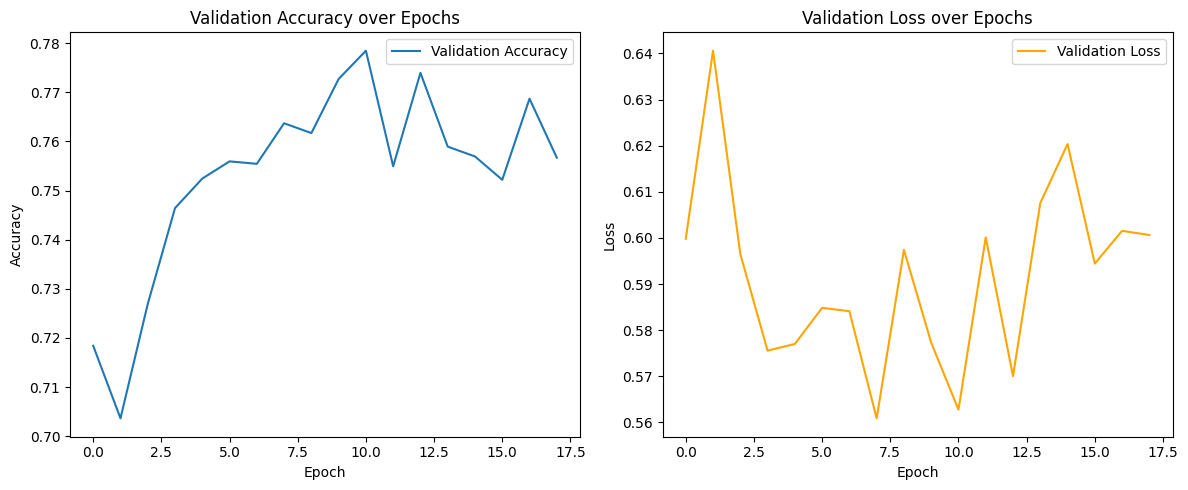


Training complete — Best Val Loss: 0.5609
Fold 1: Val = fold_1_data.txt, Train = ['fold_0_data.txt', 'fold_2_data.txt', 'fold_3_data.txt', 'fold_4_data.txt']
Reading fold file: fold_0_data.txt
Reading fold file: fold_2_data.txt
Reading fold file: fold_3_data.txt
Reading fold file: fold_4_data.txt
Reading fold file: fold_1_data.txt
Train size: 27766 (from 13883 original images)
Val size: 3609

Epoch 1/50


/home/user/mambaforge/envs/nnd/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/user/mambaforge/envs/nnd/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


TRAIN — Loss: 0.6104 | Acc: 0.6997 | Prec: 0.7083 | Rec: 0.7391 | F1: 0.7234
VAL — Loss: 0.6113 | Acc: 0.6874 | Prec: 0.6956 | Rec: 0.7743 | F1: 0.7328
Epoch 1 completed in 18.16 seconds.

Epoch 2/50
TRAIN — Loss: 0.5537 | Acc: 0.7658 | Prec: 0.7699 | Rec: 0.7975 | F1: 0.7834
VAL — Loss: 0.5864 | Acc: 0.7368 | Prec: 0.7192 | Rec: 0.8604 | F1: 0.7835
Epoch 2 completed in 35.91 seconds.

Epoch 3/50
TRAIN — Loss: 0.5369 | Acc: 0.7788 | Prec: 0.7839 | Rec: 0.8057 | F1: 0.7946
VAL — Loss: 0.6289 | Acc: 0.6858 | Prec: 0.6593 | Rec: 0.8949 | F1: 0.7592
Epoch 3 completed in 53.84 seconds.

Epoch 4/50
TRAIN — Loss: 0.5208 | Acc: 0.7910 | Prec: 0.7968 | Rec: 0.8142 | F1: 0.8054
VAL — Loss: 0.5899 | Acc: 0.7490 | Prec: 0.7826 | Rec: 0.7568 | F1: 0.7695
Epoch 4 completed in 71.36 seconds.

Epoch 5/50
TRAIN — Loss: 0.5090 | Acc: 0.7996 | Prec: 0.7996 | Rec: 0.8308 | F1: 0.8149
VAL — Loss: 0.5988 | Acc: 0.7251 | Prec: 0.7391 | Rec: 0.7783 | F1: 0.7582
Epoch 5 completed in 89.01 seconds.

Epoch 6/50


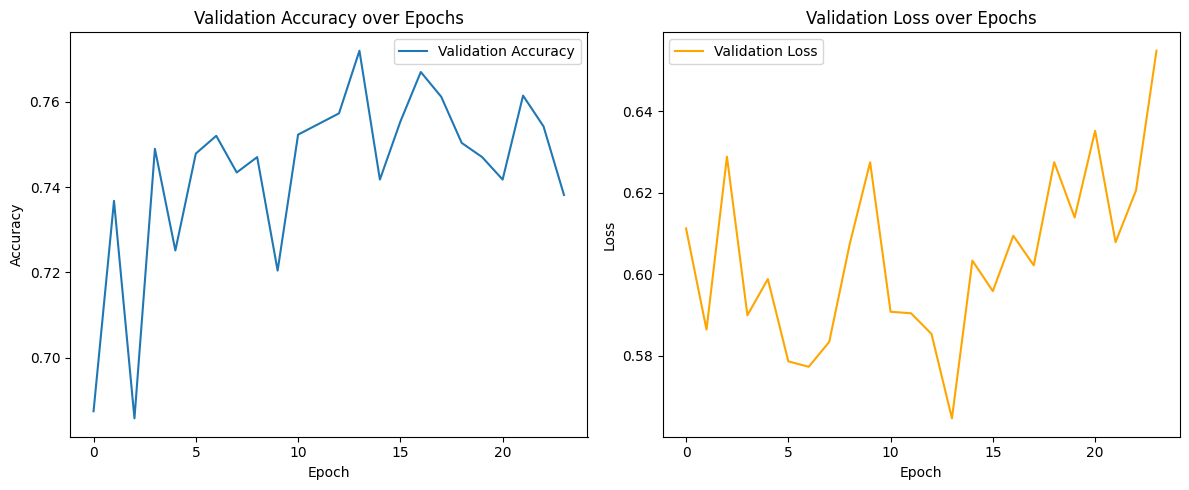


Training complete — Best Val Loss: 0.5646
Fold 2: Val = fold_2_data.txt, Train = ['fold_0_data.txt', 'fold_1_data.txt', 'fold_3_data.txt', 'fold_4_data.txt']
Reading fold file: fold_0_data.txt
Reading fold file: fold_1_data.txt
Reading fold file: fold_3_data.txt
Reading fold file: fold_4_data.txt
Reading fold file: fold_2_data.txt
Train size: 28710 (from 14355 original images)
Val size: 3137

Epoch 1/50


/home/user/mambaforge/envs/nnd/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/user/mambaforge/envs/nnd/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


TRAIN — Loss: 0.6059 | Acc: 0.7094 | Prec: 0.7187 | Rec: 0.7410 | F1: 0.7297
VAL — Loss: 0.5705 | Acc: 0.7463 | Prec: 0.7769 | Rec: 0.7734 | F1: 0.7751
Epoch 1 completed in 18.18 seconds.

Epoch 2/50
TRAIN — Loss: 0.5580 | Acc: 0.7612 | Prec: 0.7683 | Rec: 0.7859 | F1: 0.7770
VAL — Loss: 0.6111 | Acc: 0.7182 | Prec: 0.7212 | Rec: 0.8179 | F1: 0.7665
Epoch 2 completed in 36.91 seconds.

Epoch 3/50
TRAIN — Loss: 0.5440 | Acc: 0.7734 | Prec: 0.7810 | Rec: 0.7947 | F1: 0.7878
VAL — Loss: 0.5600 | Acc: 0.7619 | Prec: 0.8328 | Rec: 0.7244 | F1: 0.7748
Epoch 3 completed in 54.32 seconds.

Epoch 4/50
TRAIN — Loss: 0.5315 | Acc: 0.7860 | Prec: 0.7959 | Rec: 0.8012 | F1: 0.7985
VAL — Loss: 0.5511 | Acc: 0.7558 | Prec: 0.7772 | Rec: 0.7965 | F1: 0.7867
Epoch 4 completed in 72.36 seconds.

Epoch 5/50
TRAIN — Loss: 0.5191 | Acc: 0.7927 | Prec: 0.7993 | Rec: 0.8124 | F1: 0.8058
VAL — Loss: 0.5645 | Acc: 0.7536 | Prec: 0.8278 | Rec: 0.7125 | F1: 0.7658
Epoch 5 completed in 90.22 seconds.

Epoch 6/50


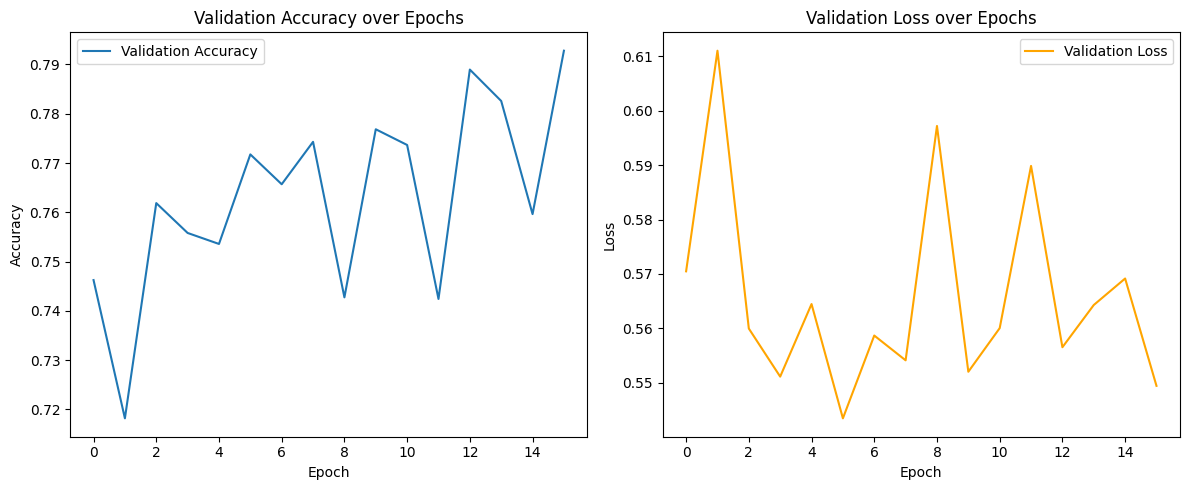


Training complete — Best Val Loss: 0.5434
Fold 3: Val = fold_3_data.txt, Train = ['fold_0_data.txt', 'fold_1_data.txt', 'fold_2_data.txt', 'fold_4_data.txt']
Reading fold file: fold_0_data.txt
Reading fold file: fold_1_data.txt
Reading fold file: fold_2_data.txt
Reading fold file: fold_4_data.txt
Reading fold file: fold_3_data.txt
Train size: 28372 (from 14186 original images)
Val size: 3306

Epoch 1/50


/home/user/mambaforge/envs/nnd/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/user/mambaforge/envs/nnd/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


TRAIN — Loss: 0.6181 | Acc: 0.6880 | Prec: 0.6991 | Rec: 0.7288 | F1: 0.7136
VAL — Loss: 0.5992 | Acc: 0.7178 | Prec: 0.8039 | Rec: 0.6386 | F1: 0.7118
Epoch 1 completed in 17.67 seconds.

Epoch 2/50
TRAIN — Loss: 0.5582 | Acc: 0.7608 | Prec: 0.7691 | Rec: 0.7884 | F1: 0.7786
VAL — Loss: 0.5904 | Acc: 0.7335 | Prec: 0.7765 | Rec: 0.7184 | F1: 0.7463
Epoch 2 completed in 35.29 seconds.

Epoch 3/50
TRAIN — Loss: 0.5372 | Acc: 0.7819 | Prec: 0.7907 | Rec: 0.8041 | F1: 0.7973
VAL — Loss: 0.5523 | Acc: 0.7747 | Prec: 0.7908 | Rec: 0.7982 | F1: 0.7945
Epoch 3 completed in 52.61 seconds.

Epoch 4/50
TRAIN — Loss: 0.5233 | Acc: 0.7913 | Prec: 0.7993 | Rec: 0.8129 | F1: 0.8060
VAL — Loss: 0.5600 | Acc: 0.7601 | Prec: 0.7965 | Rec: 0.7528 | F1: 0.7740
Epoch 4 completed in 70.62 seconds.

Epoch 5/50
TRAIN — Loss: 0.5126 | Acc: 0.7998 | Prec: 0.8093 | Rec: 0.8173 | F1: 0.8133
VAL — Loss: 0.5505 | Acc: 0.7783 | Prec: 0.7899 | Rec: 0.8088 | F1: 0.7992
Epoch 5 completed in 88.56 seconds.

Epoch 6/50


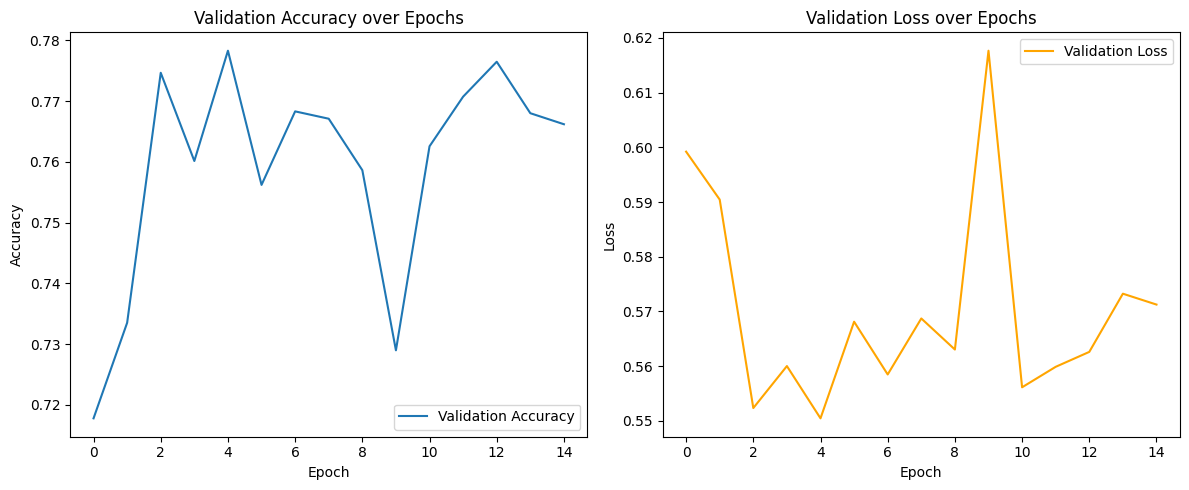


Training complete — Best Val Loss: 0.5505
Fold 4: Val = fold_4_data.txt, Train = ['fold_0_data.txt', 'fold_1_data.txt', 'fold_2_data.txt', 'fold_3_data.txt']
Reading fold file: fold_0_data.txt
Reading fold file: fold_1_data.txt
Reading fold file: fold_2_data.txt
Reading fold file: fold_3_data.txt
Reading fold file: fold_4_data.txt
Train size: 28094 (from 14047 original images)
Val size: 3445

Epoch 1/50


/home/user/mambaforge/envs/nnd/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/user/mambaforge/envs/nnd/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


TRAIN — Loss: 0.6108 | Acc: 0.6959 | Prec: 0.7027 | Rec: 0.7491 | F1: 0.7252
VAL — Loss: 0.6147 | Acc: 0.6880 | Prec: 0.7373 | Rec: 0.6499 | F1: 0.6908
Epoch 1 completed in 17.81 seconds.

Epoch 2/50
TRAIN — Loss: 0.5470 | Acc: 0.7720 | Prec: 0.7745 | Rec: 0.8103 | F1: 0.7920
VAL — Loss: 0.6888 | Acc: 0.6438 | Prec: 0.7894 | Rec: 0.4583 | F1: 0.5799
Epoch 2 completed in 35.47 seconds.

Epoch 3/50
TRAIN — Loss: 0.5300 | Acc: 0.7877 | Prec: 0.7915 | Rec: 0.8196 | F1: 0.8053
VAL — Loss: 0.6453 | Acc: 0.6970 | Prec: 0.6844 | Rec: 0.8074 | F1: 0.7408
Epoch 3 completed in 52.94 seconds.

Epoch 4/50
TRAIN — Loss: 0.5141 | Acc: 0.8013 | Prec: 0.8011 | Rec: 0.8368 | F1: 0.8186
VAL — Loss: 0.6538 | Acc: 0.6920 | Prec: 0.6781 | Rec: 0.8106 | F1: 0.7385
Epoch 4 completed in 70.51 seconds.

Epoch 5/50
TRAIN — Loss: 0.5019 | Acc: 0.8099 | Prec: 0.8111 | Rec: 0.8410 | F1: 0.8258
VAL — Loss: 0.6210 | Acc: 0.7004 | Prec: 0.7397 | Rec: 0.6813 | F1: 0.7093
Epoch 5 completed in 88.16 seconds.

Epoch 6/50


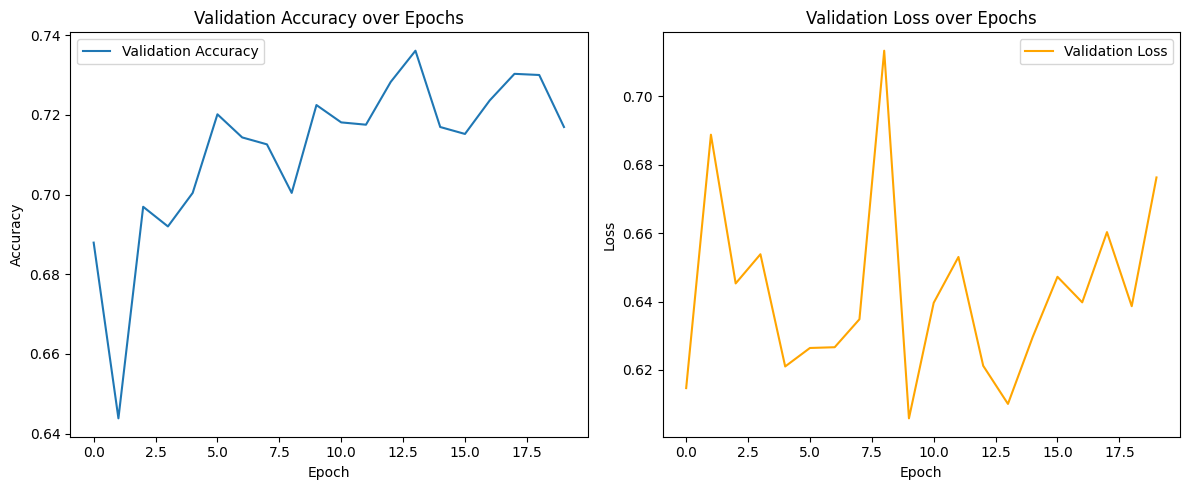


Training complete — Best Val Loss: 0.6058


In [11]:
all_folds = [f"fold_{i}_data.txt" for i in range(5)]
for fold_idx in range(5):
    val_fold = all_folds[fold_idx]
    train_folds = [f for i, f in enumerate(all_folds) if i != fold_idx]
    print(f"Fold {fold_idx}: Val = {val_fold}, Train = {train_folds}")

    dataloaders = get_dataloaders(batch_size=64, train_folds=train_folds, val_fold=val_fold)

    model = load_model(drop_rate=0.3)
    params_to_update = [p for p in model.parameters() if p.requires_grad]
    optimizer = optim.Adam(params_to_update, lr=0.001)

    model, history = train_model(model, dataloaders, optimizer, num_epochs=50)
    best_val_acc = max(history['val_acc'])

In [12]:
# Save the model
torch.save(model, 'resnet_baseline.pth')
print("Model saved as efficientnet_test.pth")

Model saved as efficientnet_test.pth
